# Demo of waveform data loading options for gw_eccentricity
 For package details, see https://pypi.org/project/gw_eccentricity.

In [6]:
from gw_eccentricity import load_waveform, load_data
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults
import matplotlib.pyplot as plt
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict # for better looking plots
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the documentation

The function `load_waveform` can be used to load waveform data into a dictionary format suitable for `gw_eccentricity` (see `gw_eccentricity_demo.ipynb`)

In [2]:
help(load_waveform)

Help on function load_waveform in module gw_eccentricity.load_data:

load_waveform(origin='LAL', **kwargs)
    Load waveform.
    
    parameters:
    ----------
    origin: str
        The origin of the waveform to be generated/loaded. This can be one of
        - "LAL": Compute waveform by a call to the LAL-library.
        - "SXSCatalog": Import waveform by reading a file in the SXS catalog
            format.
            (see https://data.black-holes.org/waveforms/documentation.html)
        - "LVCNR": Import waveform by reading a file in the LVCNR-data format.
        - "LVCNR_hack": Reading LVCNR-data format file using h5py.
            NOTE: This is NOT the recommended way to load lvcnr file.
        - "EOB": Import EOB waveform generated using SEOBNRv4EHM
            (see arxiv:2112.06952).
        - "EMRI": Import EMRI waveform generated by Maarten.
    
    kwargs:
        Kwargs dictionary to be passed to the waveform loading functions.
        Allowed kwargs depend on origi

# Available waveform `origin`s
`load_waveform` can load waveforms of different "origins" like the SXS NR Catalog or the LIGO Algorithm Library (`LAL`). Available`origin`s and the corresponding function it calls to load the waveform data can be obtained using `get_available_waveform_origins()`

In [3]:
get_available_waveform_origins()

{'LAL': <function gw_eccentricity.load_data.load_LAL_waveform(**kwargs)>,
 'SXSCatalog': <function gw_eccentricity.load_data.load_sxs_catalogformat(**kwargs)>,
 'LVCNR': <function gw_eccentricity.load_data.load_lvcnr_waveform(**kwargs)>,
 'LVCNR_hack': <function gw_eccentricity.load_data.load_lvcnr_hack(**kwargs)>,
 'EOB': <function gw_eccentricity.load_data.load_EOB_waveform(**kwargs)>,
 'EMRI': <function gw_eccentricity.load_data.load_EMRI_waveform(**kwargs)>}

## Load waveform data using `LAL`

To generate waveform using models in `LALSuite` call `load_waveform` with `origin="LAL"` and relevant `kwargs`.<br>
The allowed kwargs and defaults values can be obtained using `get_load_waveform_defaults("LAL")`

In [4]:
get_load_waveform_defaults("LAL")

{'approximant': 'EccentricTD',
 'q': 1.0,
 'chi1': [0.0, 0.0, 0.0],
 'chi2': [0.0, 0.0, 0.0],
 'ecc': 1e-05,
 'mean_ano': 0.0,
 'Momega0': 0.01,
 'deltaTOverM': 0.1,
 'physicalUnits': False,
 'M': None,
 'D': None,
 'include_zero_ecc': False}

In [8]:
# Uncomment below and run to get details of allowed kwargs for origin='LAL'
#help(load_data.load_LAL_waveform)

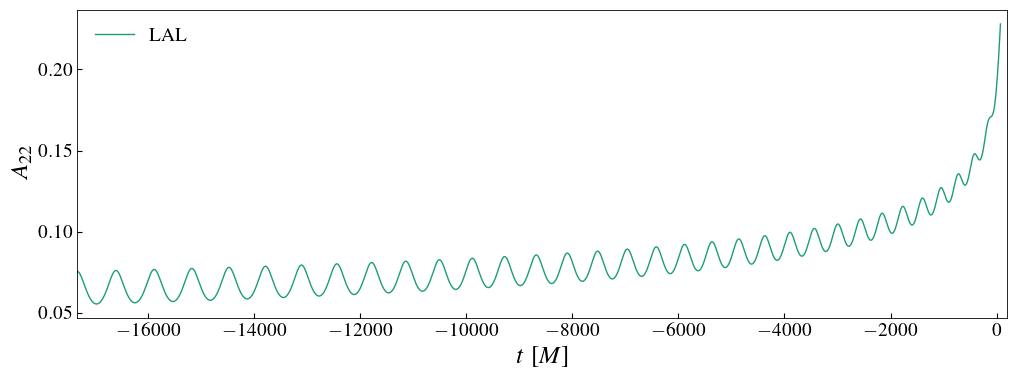

In [5]:
kwargs = {"q": 2.0,
          "ecc": 0.1}
origin = "LAL"
dataDict = load_waveform(origin, **kwargs)
use_fancy_plotsettings() # use better defaults for plotting
fig, ax = plt.subplots(figsize=(12, 4))
# Plot the amplitude of the (2,2) mode
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label=origin)
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

## Load waveform data from SXS catalog format file
Waveform data from a file in [SXS catalog format](https://data.black-holes.org/waveforms/documentation.html) can be loaded using `origin="SXSCatalog"` and providing necessary `kwargs`.

The allowed `kwargs` and their default values can be obtained using `get_load_waveform_defaults("SXSCatalog")`

In [6]:
origin = "SXSCatalog"
get_load_waveform_defaults(origin)

{'filepath': None,
 'metadata_path': None,
 'deltaTOverM': 0.1,
 'include_zero_ecc': False,
 'zero_ecc_approximant': 'IMRPhenomT',
 'num_orbits_to_remove_as_junk': 2,
 'mode_array': [(2, 2)],
 'extrap_order': 2}

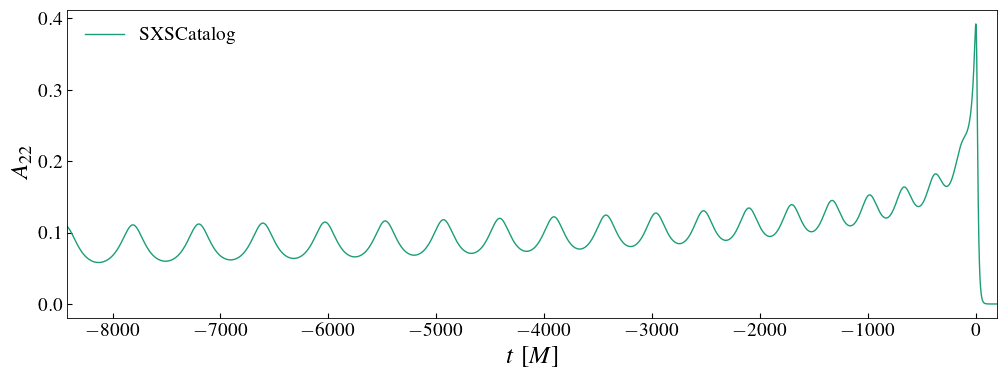

In [7]:
# Load nr data from sxs catalog format file using only filepath and default values for other kwargs
kwargs = {"filepath": "data/rhOverM_Asymptotic_GeometricUnits_CoM.h5"}
dataDict = load_waveform(origin, **kwargs)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label=origin)
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

### Load quasicircular counterpart for SXSCatalog format
For measuring eccentricity using residual methods like `ResidualAmplitude`, we need to include the quasicircular counterpart also in the `dataDict`. This can be done by setting `include_zero_ecc` to `True`,
and providing the path to the simulation metadata (`metadata_path`; look for `metadata.txt` that comes alongside `rhOverM_Asymptotic_GeometricUnits_CoM.h5`), so that the correct parameters for generating the quasicircular counterpart can be used.

One can also choose what waveform model to use for generating quasicircular waveform via `zero_ecc_approximant`. The default is `IMRPhenomT`.

**NOTE:** `SEOBNRv4ROM_v2.0.hdf5` is required in `LAL_DATA_PATH` to get an estimate for the initial
frequency for generating the quasicircular waveform. Download it from https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/SEOBNRv4ROM_v2.0.hdf5
and set the path using
```bash
export LAL_DATA_PATH=/path/to/directory/containing/seobnrv4rom_file/
```

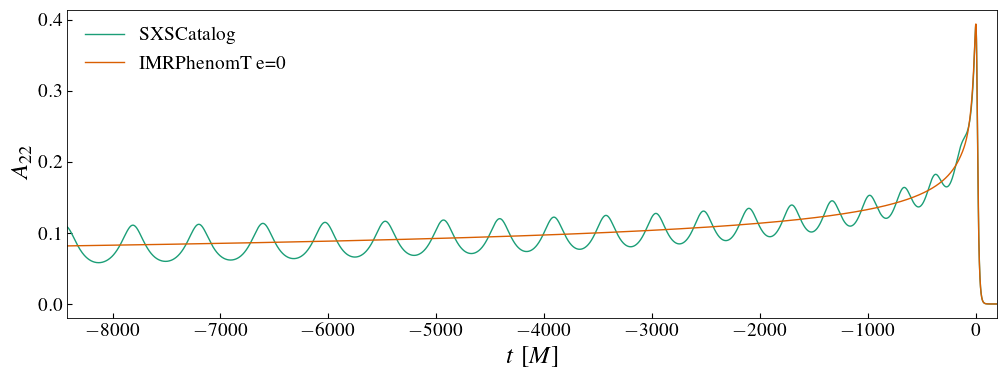

In [8]:
kwargs = {"filepath": "data/rhOverM_Asymptotic_GeometricUnits_CoM.h5",
         "metadata_path": "data/metadata.txt",
         "include_zero_ecc": True,
         "zero_ecc_approximant": "IMRPhenomT"}
dataDict = load_waveform(origin, **kwargs)

# use better defaults for plotting
use_fancy_plotsettings()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label=origin)
ax.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label=kwargs["zero_ecc_approximant"] + " e=0")
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

## Load waveform data from `LVCNR` format file
Waveform data from a file in `LVCNR` format can be loaded using `origin="LVCNR"` and providing necessary `kwargs`.

The allowed `kwargs` and defaults can be obtained using `get_load_waveform_defaults("LVCNR")`

In [9]:
origin = "LVCNR"
get_load_waveform_defaults(origin)

{'filepath': None,
 'deltaTOverM': 0.1,
 'Momega0': 0.0,
 'include_zero_ecc': False,
 'zero_ecc_approximant': 'IMRPhenomT',
 'num_orbits_to_remove_as_junk': 2}

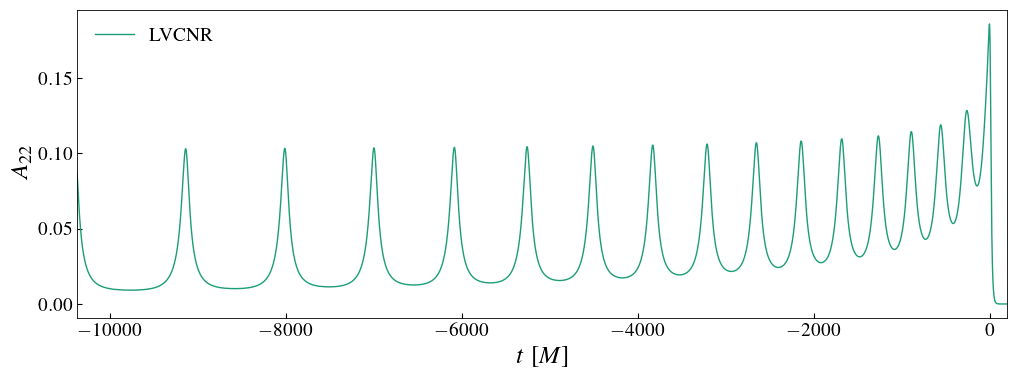

In [10]:
# Load nr data from LVCNR format file using only filepath and using defaults for other kwargs
kwargs = {"filepath": "data/BBH_SHK_q6_e095_D65_Res3.h5"}
dataDict = load_waveform(origin=origin, **kwargs)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label=origin)
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")